In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import geopandas as gpd
import ee
import geemap
from greensight.utils import DIR_DATA

In [2]:

ee.Authenticate()
ee.Initialize(project='plottosat-fjgibson')

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [3]:
data_dir = Path("/home/finley/GoogleDrive/Greenbelts_2021_test_all_inds")
data_path = data_dir / "feature_vectors__0000000170_0000000174_S2_full_collection.csv"


In [4]:
df = pd.read_csv(data_path)
df.head()

,system:index,LAD_CD,bandName,mean,stdDev,.geo
0,1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...,E07000197,0_B8,2571.804279,1672.033044,"{""type"":""GeometryCollection"",""geometries"":[{""t..."
1,1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...,E07000198,0_B8,4265.511925,2406.433524,"{""type"":""MultiPolygon"",""coordinates"":[[[[-2.07..."
2,1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...,E06000021,0_B8,4125.762291,2436.193593,"{""type"":""MultiPolygon"",""coordinates"":[[[[-2.11..."
3,1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...,E06000047,0_B8,4340.286735,2351.161997,"{""type"":""GeometryCollection"",""geometries"":[{""t..."
4,1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_1_...,E08000037,0_B8,4211.495749,2770.894066,"{""type"":""GeometryCollection"",""geometries"":[{""t..."


In [5]:
# set location of data file
shapes_path = DIR_DATA / "shapes/England_Green_Belt_2022_23_WGS84/England_Green_Belt_2022_23_WGS84.shp"

In [6]:
# read data
df_shapes = gpd.read_file(shapes_path)
df_shapes.head()

,LAD_NM,LAD_CD,GB_Name,Area_ha,geometry
0,Amber Valley,E07000032,Derby and Nottingham,8647.904471,"MULTIPOLYGON (((-1.34303 53.071, -1.34304 53.0..."
1,Ashfield,E07000170,Derby and Nottingham,4521.598181,"MULTIPOLYGON (((-1.18089 53.11499, -1.18089 53..."
2,Barking and Dagenham,E09000002,London,527.776471,"MULTIPOLYGON (((0.15314 51.56697, 0.15325 51.5..."
3,Barnet,E09000003,London,2383.047837,"MULTIPOLYGON (((-0.20927 51.63758, -0.20937 51..."
4,Barnsley,E08000016,South and West Yorkshire,22393.050084,"MULTIPOLYGON (((-1.27572 53.52946, -1.27574 53..."


MultiPolygon


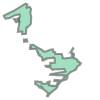

In [7]:
geometry = df_shapes.loc[2]["geometry"]
print(geometry.geom_type)
geometry

In [8]:
# Convert to GeoJSON first
geometry_geojson = geometry.__geo_interface__

# Convert to Earth Engine geometry
ee_geometry = ee.Geometry(geometry_geojson)

# Check the geometry in Earth Engine
print(ee_geometry.getInfo())

{'type': 'MultiPolygon', 'coordinates': [[[[0.1531353424192615, 51.56697248779957], [0.15325199290642424, 51.5668912130371], [0.15333715883823176, 51.56683074751248], [0.1534495683119519, 51.56675134884526], [0.15351624466774974, 51.56670510050068], [0.15366016962284149, 51.566599478242935], [0.15375142620963425, 51.566540530136535], [0.15382465954018826, 51.56648997291534], [0.15383865298831306, 51.56648000580162], [0.1538381497092854, 51.56647924883466], [0.1540816993754033, 51.566295509398756], [0.15430252719686702, 51.566143976011], [0.1543778983647274, 51.56609248520829], [0.15437886299738254, 51.566091829019946], [0.1546799410487807, 51.56588615148831], [0.1548110868781082, 51.56579111877926], [0.1551242137166553, 51.565547061983786], [0.15524471609175206, 51.56547110910627], [0.1554877984139088, 51.56533265327471], [0.15550072408518628, 51.565326063296794], [0.15550095926753585, 51.56532590538613], [0.15550132002186898, 51.5653257214622], [0.1555508262774286, 51.56529237835633],

In [9]:
ee_geometry = ee.Geometry(geometry.__geo_interface__)
ee_geometry = ee.Geometry(geometry_geojson)

In [16]:

# shapefile = ee.FeatureCollection('projects/plottosat-fjgibson/assets/greenbelts')

# Load the Sentinel-1 ImageCollection, filter to Jun-Sep 2020 observations.
sentinel_1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterDate('2020-06-01', '2020-07-01') \
    .filterBounds(ee_geometry)  

# Filter the Sentinel-1 collection by metadata properties.
vv_vh_iw = (
    sentinel_1.filter(
        # Filter to get images with VV and VH dual polarization.
        ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')
    )
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
    .filter(
        # Filter to get images collected in interferometric wide swath mode.
        ee.Filter.eq('instrumentMode', 'IW')
    )
)

In [17]:
# Separate ascending and descending orbit images into distinct collections.
vv_vh_iw_asc = vv_vh_iw.filter(
    ee.Filter.eq('orbitProperties_pass', 'ASCENDING')
)
vv_vh_iw_desc = vv_vh_iw.filter(
    ee.Filter.eq('orbitProperties_pass', 'DESCENDING')
)


In [18]:
# Calculate temporal means for various observations to use for visualization.
# Mean VH ascending.
vh_iw_asc_mean = vv_vh_iw_asc.select('VH').mean()
# Mean VH descending.
vh_iw_desc_mean = vv_vh_iw_desc.select('VH').mean()
# Mean VV for combined ascending and descending image collections.
vv_iw_asc_desc_mean = vv_vh_iw_asc.merge(vv_vh_iw_desc).select('VV').mean()
# Mean VH for combined ascending and descending image collections.
vh_iw_asc_desc_mean = vv_vh_iw_asc.merge(vv_vh_iw_desc).select('VH').mean()


In [19]:
vh_iw_asc_desc = vv_vh_iw_asc.merge(vv_vh_iw_desc).select('VH')
vh_iw_asc_desc

In [ ]:
# Display the temporal means for various observations, compare them.
m = geemap.Map()
m.add_layer(vv_iw_asc_desc_mean, {'min': -12, 'max': -4}, 'vv_iw_asc_desc_mean')
m.add_layer(
    vh_iw_asc_desc_mean, {'min': -18, 'max': -10}, 'vh_iw_asc_desc_mean'
)
m.add_layer(vh_iw_asc_mean, {'min': -18, 'max': -10}, 'vh_iw_asc_mean')
m.add_layer(vh_iw_desc_mean, {'min': -18, 'max': -10}, 'vh_iw_desc_mean')
m.add_layer(ee_geometry)
m.set_center(0.13, 51.5, 9)  # London, 
m

Map(center=[51.5, 0.13], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [29]:
# Check the band names
# print(vh_iw_asc_desc_mean.bandNames().getInfo())

# Check the dimensions for a specific band
band_info = vh_iw_asc_desc_mean.select('VH').getInfo()  # replace 'vh' with the actual band name
print("Band 'vh' dimensions:", band_info['bands'][0])

Band 'vh' dimensions: {'id': 'VH', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}
